In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_masks.csv', 'sample_submission.csv', 'train']


In [2]:
t_mask = pd.read_csv("../input/train_masks.csv")
t_mask.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [3]:
## Imports

import sys
import random

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


In [4]:
dataset_path = "../input/"
train_path = os.path.join(dataset_path, "train/")

In [5]:
  def load(path, id_name,image_size):
        ## Path
        image_path = path+id_name+".tif"
        mask_path =  path+id_name+"_mask"+".tif"
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size,image_size))
        
        ##Reading Mask
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (image_size,image_size))
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask


In [6]:
def batch_load(path,train_ids,image_size):
    image = []
    mask  = []
    
    for id_name in train_ids:
        _img, _mask = load(path,id_name,image_size)
        image.append(_img)
        mask.append(_mask)
            
    image = np.array(image)
    mask  = np.array(mask)
    
    
    return image,mask

In [7]:
train_csv = pd.read_csv(dataset_path + "train_masks.csv")
train_csv.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [8]:
train_id = []
for index,rows in train_csv.iterrows():
    train_id.append((str(rows[0])+'_'+str(rows[1])))

In [9]:
image_size = 128

In [10]:
image,mask = batch_load(train_path,train_id,image_size)

In [11]:
split =4000
x_train = image[:split] 
y_train = mask[:split]
x_test  = image[split:]
y_test  = mask[split:]

In [12]:
print(x_train[0].shape)
print(y_train[0].shape)



(128, 128, 3)
(128, 128, 1)


5057


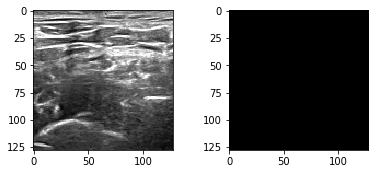

In [13]:


r = random.randint(0, len(image)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(mask[r]*255, (image_size, image_size)), cmap="gray")



In [14]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c


In [15]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [16]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_norm

In [18]:
!cd .. && mkdir output

In [19]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath='/kaggle/output/model.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# called every epoch
callbacks = [lr_reducer, checkpoint]

In [20]:
# train the ResUNet
model.fit(x_train,
                y_train,
                validation_data=(x_test, y_test),
                epochs=20,
                batch_size=16,
         callbacks=callbacks)

Train on 4000 samples, validate on 1635 samples
Epoch 1/20
3984/4000 [============================>.] - ETA: 0s - loss: 0.5514 - dice_coef: 0.4486
Epoch 00001: val_loss improved from inf to 0.92751, saving model to /kaggle/output/model.h5
4000/4000 [==============================] - 34s 9ms/sample - loss: 0.5509 - dice_coef: 0.4491 - val_loss: 0.9275 - val_dice_coef: 0.0729
Epoch 2/20
3984/4000 [============================>.] - ETA: 0s - loss: 0.4534 - dice_coef: 0.5466
Epoch 00002: val_loss improved from 0.92751 to 0.81015, saving model to /kaggle/output/model.h5
4000/4000 [==============================] - 21s 5ms/sample - loss: 0.4540 - dice_coef: 0.5460 - val_loss: 0.8101 - val_dice_coef: 0.1910
Epoch 3/20
3984/4000 [============================>.] - ETA: 0s - loss: 0.4263 - dice_coef: 0.5737
Epoch 00003: val_loss improved from 0.81015 to 0.51673, saving model to /kaggle/output/model.h5
4000/4000 [==============================] - 22s 5ms/sample - loss: 0.4263 - dice_coef: 0.5737 

In [21]:
!cd /kaggle/output && ls

model.h5


In [22]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/output/model.h5',custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss})



 Input       Ground Truth            Predicted Value


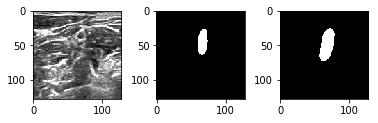

In [23]:
## Dataset for prediction
print("\n Input       Ground Truth            Predicted Value")

r = random.randint(0, len(image)-1)

x, y = image[r],mask[r]
x_inp=x.reshape(1,128,128,3)
result = model.predict(x_inp)

result = result > 0.5

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
plt.imshow(np.reshape(result*255, (image_size, image_size)), cmap="gray")


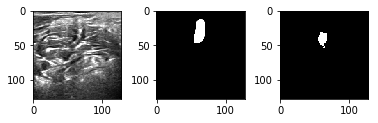

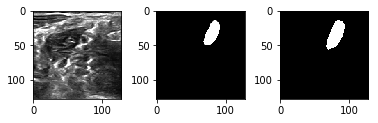

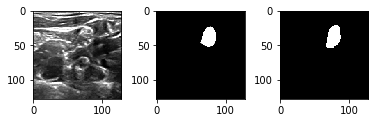

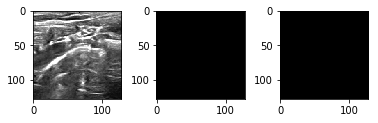

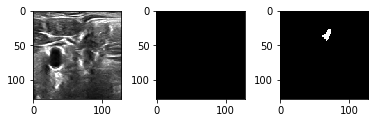

In [24]:
for i in range(5):
    
    r = random.randint(0, len(image)-1)

    x, y = image[r],mask[r]
    x_inp=x.reshape(1,128,128,3)
    result = model.predict(x_inp)

    result = result > 0.5

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(np.reshape(result*255, (image_size, image_size)), cmap="gray")

    